Transfer Learning for Computer Vision Tutorial
==============================================

**Author**: [Sasank Chilamkurthy](https://chsasank.github.io)

In this tutorial, you will learn how to train a convolutional neural
network for image classification using transfer learning. You can read
more about the transfer learning at [cs231n
notes](https://cs231n.github.io/transfer-learning/)

Quoting these notes,

> In practice, very few people train an entire Convolutional Network
> from scratch (with random initialization), because it is relatively
> rare to have a dataset of sufficient size. Instead, it is common to
> pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
> contains 1.2 million images with 1000 categories), and then use the
> ConvNet either as an initialization or a fixed feature extractor for
> the task of interest.

These two major transfer learning scenarios look as follows:

-   **Finetuning the ConvNet**: Instead of random initialization, we
    initialize the network with a pretrained network, like the one that
    is trained on imagenet 1000 dataset. Rest of the training looks as
    usual.
-   **ConvNet as fixed feature extractor**: Here, we will freeze the
    weights for all of the network except that of the final fully
    connected layer. This last fully connected layer is replaced with a
    new one with random weights and only this layer is trained.


In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import transforms
from torchvision.transforms import InterpolationMode
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from collections import Counter
from tempfile import TemporaryDirectory
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR, LambdaLR, OneCycleLR
import random
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix, f1_score


cudnn.benchmark = True
plt.ion()   # interactive mode

Load Data
=========

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we\'re going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants
and bees. There are 75 validation images for each class. Usually, this
is a very small dataset to generalize upon, if trained from scratch.
Since we are using transfer learning, we should be able to generalize
reasonably well.

This dataset is a very small subset of imagenet.


In [2]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
# Hyperparameters
num_epochs = 20
lr= 1e-3  # higher lr for classifier
momentum = 0.9
step_size = 7 
gamma = 0.1
weight_decay = 1e-4
batch_size = 64
patience = 3
label_smoothing = 0.05
warmup_epochs = 2

In [4]:

# # Load the .npy dataset
# path_to_fer = 'fer13_v2.npy'
# m = np.load(path_to_fer, allow_pickle=True).item()
# x_train, y_train = m['train']
# x_val, y_val = m['val']
# x_test, y_test = m['test']

# # Define custom dataset class
# class FERDataset(Dataset):
#     def __init__(self, images, labels, transform=None):
#         self.images = images
#         self.labels = labels
#         self.transform = transform
    
#     def __len__(self):
#         return len(self.images)
    
#     def __getitem__(self, idx):
#         image = self.images[idx].astype(np.uint8)
#         label = int(self.labels[idx])  # Ensure label is an integer
#         return self.transform(image), label

# # Define transformations
# data_transforms = {
#     'train': transforms.Compose([
#         transforms.ToPILImage(),
#         transforms.Resize((224, 224)),  # Resize from 48x48 to 224x224
#         transforms.Grayscale(num_output_channels=3),  # Convert 1-channel to 3-channel
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize([0.5], [0.5])  # Normalize for grayscale
#     ]),
#     'val': transforms.Compose([
#         transforms.ToPILImage(),
#         transforms.Resize((224, 224)),  # Resize from 48x48 to 224x224
#         transforms.Grayscale(num_output_channels=3),  # Convert 1-channel to 3-channel
#         transforms.ToTensor(),
#         transforms.Normalize([0.5], [0.5])  # Normalize for grayscale
#     ]),
# }

# # Create datasets
# datasets = {
#     'train': FERDataset(x_train, y_train, transform=data_transforms['train']),
#     'val': FERDataset(x_val, y_val, transform=data_transforms['val']),
#     'test': FERDataset(x_test, y_test, transform=data_transforms['val'])
# }

# # Create dataloaders
# dataloaders = {
#     x: DataLoader(datasets[x], batch_size=batch_size, shuffle=True, num_workers=4)
#     for x in ['train', 'val', 'test']
# }

# dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val', 'test']}

# # Get the number of unique classes in the dataset
# num_classes = len(np.unique(np.concatenate([y_train, y_val, y_test])))

# print(f"Number of classes: {num_classes}")


# # Select device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using {device} device")

In [5]:
# Load the .npy dataset
path_to_fer = 'fer13_v2.npy'
m = np.load(path_to_fer, allow_pickle=True).item()
x_train, y_train = m['train']
x_val, y_val = m['val']
x_test, y_test = m['test']

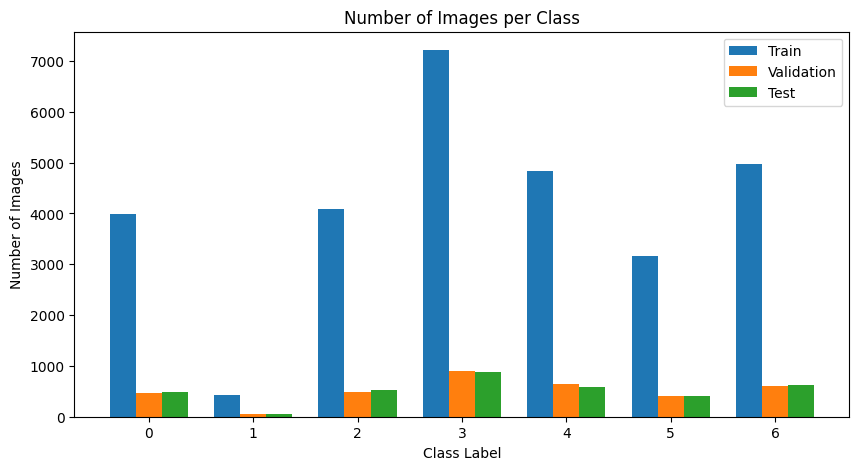

In [6]:

# Count the number of samples per class for each dataset
train_counts = Counter(y_train)
val_counts = Counter(y_val)
test_counts = Counter(y_test)

# Get sorted class labels
class_labels = sorted(set(y_train) | set(y_val) | set(y_test))

# Create a bar plot
fig, ax = plt.subplots(figsize=(10, 5))
bar_width = 0.25
index = np.arange(len(class_labels))

ax.bar(index, [train_counts[c] for c in class_labels], bar_width, label='Train')
ax.bar(index + bar_width, [val_counts[c] for c in class_labels], bar_width, label='Validation')
ax.bar(index + 2 * bar_width, [test_counts[c] for c in class_labels], bar_width, label='Test')

ax.set_xlabel('Class Label')
ax.set_ylabel('Number of Images')
ax.set_title('Number of Images per Class')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(class_labels)
ax.legend()

plt.show()

In [7]:
TARGET_COUNT = 4000

# Count the number of samples per class in training set
train_counts = Counter(y_train)

# Data augmentation for training set
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((384, 384), interpolation=InterpolationMode.BILINEAR),
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3-channel
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Match EfficientNet normalization
])

# **No augmentation for validation and test sets**
val_test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((384, 384), interpolation=InterpolationMode.BILINEAR),
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3-channel
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Balance dataset by removing excess images and augmenting underrepresented classes
balanced_x_train = []
balanced_y_train = []

for label in train_counts:
    indices = [i for i, y in enumerate(y_train) if y == label]
    if train_counts[label] > TARGET_COUNT:
        # Randomly select TARGET_COUNT images
        selected_indices = random.sample(indices, TARGET_COUNT)
    else:
        # Keep all images and perform augmentation to reach TARGET_COUNT
        selected_indices = indices.copy()
        while len(selected_indices) < TARGET_COUNT:
            selected_indices.append(random.choice(indices))
    
    for idx in selected_indices:
        balanced_x_train.append(x_train[idx])
        balanced_y_train.append(y_train[idx])

# Convert balanced dataset to numpy arrays
balanced_x_train = np.array(balanced_x_train)
balanced_y_train = np.array(balanced_y_train)

# Define dataset class
class FERDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].astype(np.uint8)
        label = int(self.labels[idx])
        return self.transform(image), label

# Create datasets with appropriate transforms
datasets = {
    'train': FERDataset(balanced_x_train, balanced_y_train, transform=train_transforms),
    'val': FERDataset(x_val, y_val, transform=val_test_transforms),  # No augmentation
    'test': FERDataset(x_test, y_test, transform=val_test_transforms)  # No augmentation
}

# Get the number of unique classes in the dataset
num_classes = len(np.unique(np.concatenate([y_train, y_val, y_test])))

print(f"Number of classes: {num_classes}")

# Create dataloaders
dataloaders = {
    x: DataLoader(datasets[x], batch_size=batch_size, shuffle=(x == 'train'), num_workers=4)
    for x in ['train', 'val', 'test']
}

# Count final dataset sizes
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val', 'test']}

print(f"Final dataset sizes: {dataset_sizes}")

Number of classes: 7
Final dataset sizes: {'train': 28000, 'val': 3589, 'test': 3589}


In [8]:
dataset_sizes

{'train': 28000, 'val': 3589, 'test': 3589}

Visualize a few images
======================

Let\'s visualize a few training images so as to understand the data
augmentations.


In [9]:
# def show_sample_images(dataloader, num_images=6):
#     images_shown = 0
#     fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
#     for images, labels in dataloader:
#         for i in range(num_images):
#             image = images[i].permute(1, 2, 0).numpy() * 0.5 + 0.5
#             axes[i].imshow(image, cmap='gray')
#             axes[i].set_title(f"Label: {labels[i]}")
#             axes[i].axis('off')
#             images_shown += 1
#             if images_shown >= num_images:
#                 plt.show()
#                 return
            
# # Show sample images
# show_sample_images(dataloaders['train'])

Training the model
==================

Now, let\'s write a general function to train a model. Here, we will
illustrate:

-   Scheduling the learning rate
-   Saving the best model

In the following, parameter `scheduler` is an LR scheduler object from
`torch.optim.lr_scheduler`.


In [10]:

# Function to calculate combined metric
def calculate_combined_metric(accuracy, f1_score):
    return 0.5 * (accuracy + f1_score)

# Modified training function
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, patience=5, grad_clip=1.0):
    since = time.time()
    
    # Create models directory
    model_dir = "models"
    os.makedirs(model_dir, exist_ok=True)
    best_model_path = os.path.join(model_dir, 'best_model.pth')
    
    best_combined_metric = 0.0
    patience_counter = 0
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    train_f1_scores, val_f1_scores = [], []
    train_combined_metrics, val_combined_metrics = [], []
    learning_rates = []
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            all_preds = []
            all_labels = []
            
            for batch_idx, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        # Gradient clipping to prevent exploding gradients
                        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                # Collect predictions and labels for F1 score
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
            
            # Step the scheduler after the epoch (for OneCycleLR)
            if phase == 'train':
                scheduler.step()
                # Log the learning rate
                current_lr = optimizer.param_groups[0]['lr']
                learning_rates.append(current_lr)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_f1 = f1_score(all_labels, all_preds, average='weighted')
            epoch_combined_metric = calculate_combined_metric(epoch_acc.item(), epoch_f1)
            
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.item())
                train_f1_scores.append(epoch_f1)
                train_combined_metrics.append(epoch_combined_metric)
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.item())
                val_f1_scores.append(epoch_f1)
                val_combined_metrics.append(epoch_combined_metric)
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {epoch_f1:.4f} Combined: {epoch_combined_metric:.4f}')
            
            if phase == 'val' and epoch_combined_metric > best_combined_metric:
                best_combined_metric = epoch_combined_metric
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'best_combined_metric': best_combined_metric,
                }, best_model_path)
                patience_counter = 0  # Reset early stopping counter
            elif phase == 'val':
                patience_counter += 1
        
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break
        
        print()
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Combined Metric: {best_combined_metric:.4f}')
    
    # Load best model
    checkpoint = torch.load(best_model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Plot training results
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 3, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training & Validation Loss')
    
    plt.subplot(2, 3, 2)
    plt.plot(train_accuracies, label='Train Acc')
    plt.plot(val_accuracies, label='Val Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training & Validation Accuracy')
    
    plt.subplot(2, 3, 3)
    plt.plot(train_f1_scores, label='Train F1')
    plt.plot(val_f1_scores, label='Val F1')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.title('Training & Validation F1 Score')
    
    plt.subplot(2, 3, 4)
    plt.plot(train_combined_metrics, label='Train Combined')
    plt.plot(val_combined_metrics, label='Val Combined')
    plt.xlabel('Epochs')
    plt.ylabel('Combined Metric')
    plt.legend()
    plt.title('Training & Validation Combined Metric')
    
    plt.subplot(2, 3, 5)
    plt.plot(learning_rates, label='Learning Rate')
    plt.xlabel('Steps')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.title('Learning Rate Schedule')
    
    plt.tight_layout()
    plt.show()
    
    return model


Visualizing the model predictions
=================================

Generic function to display predictions for a few images


In [11]:
# Function to unnormalize and show an image
def imshow(img):
    """Display a tensor image (Grayscale or RGB)"""
    img = img.numpy().transpose((1, 2, 0))  # Convert from Tensor format (C, H, W) to (H, W, C)
    img = img * 0.5 + 0.5  # Unnormalize (assuming Normalize([0.5], [0.5]))
    
    if img.shape[-1] == 1:  # If the image is grayscale, remove the last dimension
        img = img.squeeze(-1)
    
    plt.imshow(img, cmap="gray" if len(img.shape) == 2 else None)  # Use 'gray' colormap if grayscale
    plt.axis("off")

# Function to visualize model predictions
def visualize_model(model, num_images=6):
    """Visualizes model predictions on the validation set"""
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(10, num_images * 2))

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size(0)):
                images_so_far += 1
                ax = plt.subplot((num_images + 1) // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title(f'Predicted: {preds[j].item()} | True: {labels[j].item()}')
                
                imshow(inputs.cpu().data[j])  # Show image

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
    model.train(mode=was_training)

Finetuning the ConvNet
======================

Load a pretrained model and reset final fully connected layer.


In [12]:

# Step 1: Load and modify the model
model_ft = models.efficientnet_v2_s(weights="IMAGENET1K_V1")
num_ftrs = model_ft.classifier[1].in_features

# Define a small FCN classifier
model_ft.classifier = nn.Sequential(
    nn.Dropout(p=0.5),  # Dropout before the first layer
    nn.Linear(num_ftrs, 512),  # First hidden layer
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Linear(512, num_classes)  # Output layer
)

# Freeze entire model first
for param in model_ft.parameters():
    param.requires_grad = False

# Unfreeze classifier parameters
for param in model_ft.classifier.parameters():
    param.requires_grad = True

model_ft = model_ft.to(device)

# Define loss function with label smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

# Step 4: Set up optimizer (AdamW is better for weight decay handling)
optimizer_ft = optim.AdamW(model_ft.classifier.parameters(), lr=lr, weight_decay=weight_decay)

# Step 5: One-cycle learning rate scheduler (more stable than cosine)
scheduler = OneCycleLR(optimizer_ft, 
                      max_lr=1e-3, 
                      steps_per_epoch=len(dataloaders['train']), 
                      epochs=num_epochs, 
                      pct_start=0.1)  # Warm-up for 10% of training

Train and evaluate
==================

It should take around 15-25 min on CPU. On GPU though, it takes less
than a minute.


Epoch 0/19
----------
train Loss: 1.9016 Acc: 0.2184 F1: 0.2131 Combined: 0.2158
val Loss: 1.8484 Acc: 0.2619 F1: 0.2566 Combined: 0.2593

Epoch 1/19
----------
train Loss: 1.8218 Acc: 0.2809 F1: 0.2705 Combined: 0.2757
val Loss: 1.8110 Acc: 0.2848 F1: 0.2762 Combined: 0.2805

Epoch 2/19
----------
train Loss: 1.7977 Acc: 0.2951 F1: 0.2844 Combined: 0.2897
val Loss: 1.8051 Acc: 0.2906 F1: 0.2840 Combined: 0.2873

Epoch 3/19
----------
train Loss: 1.7871 Acc: 0.3017 F1: 0.2904 Combined: 0.2961
val Loss: 1.8513 Acc: 0.2990 F1: 0.3057 Combined: 0.3023

Epoch 4/19
----------
train Loss: 1.7816 Acc: 0.3060 F1: 0.2951 Combined: 0.3006
val Loss: 1.7880 Acc: 0.3190 F1: 0.3031 Combined: 0.3111

Epoch 5/19
----------
train Loss: 1.7705 Acc: 0.3137 F1: 0.3015 Combined: 0.3076
val Loss: 1.7916 Acc: 0.3185 F1: 0.3128 Combined: 0.3156

Epoch 6/19
----------
train Loss: 1.7652 Acc: 0.3144 F1: 0.3034 Combined: 0.3089
val Loss: 1.7589 Acc: 0.3204 F1: 0.3188 Combined: 0.3196

Epoch 7/19
----------
train

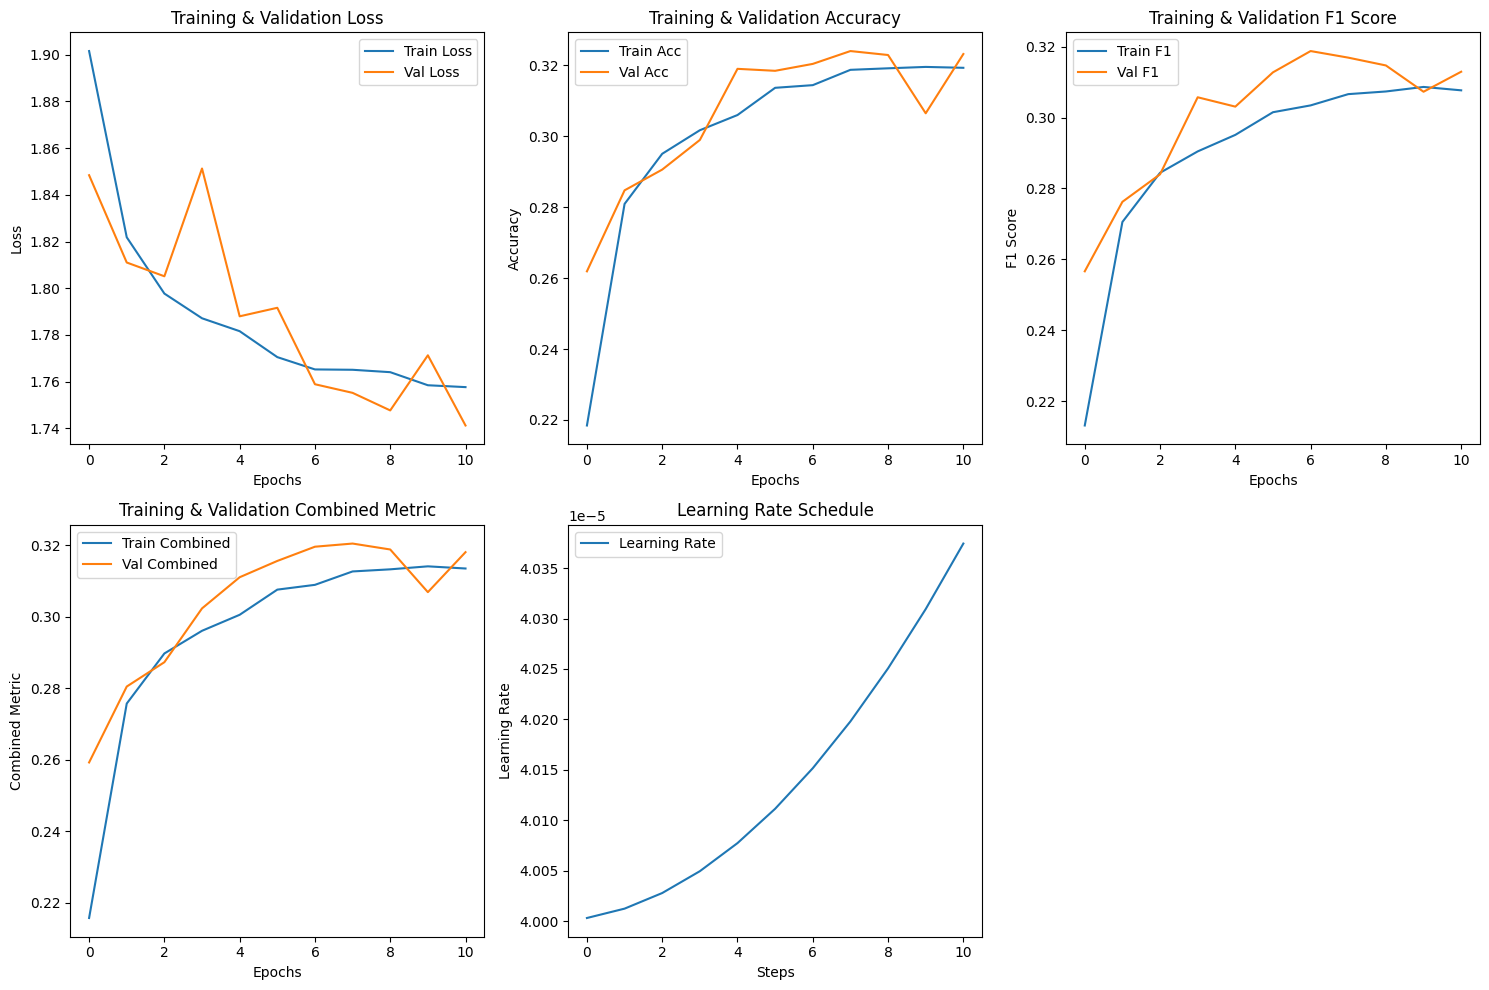

In [13]:

# Run training

model_ft = train_model(model_ft, criterion, optimizer_ft, scheduler, num_epochs=num_epochs, patience=patience)

In [14]:
def evaluate_model(model, dataloader, num_classes, device):
    model.eval()  # Set model to evaluation mode
    y_true = []
    y_pred = []
    y_prob = []  # Store probability scores for AUC calculation

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)  # Forward pass

            probs = torch.softmax(outputs, dim=1)  # Convert logits to probabilities
            _, preds = torch.max(outputs, 1)  # Get predicted class

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_prob.extend(probs.cpu().numpy())  # Store probabilities

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Compute classification report (Precision, Recall, F1-score)
    class_report = classification_report(y_true, y_pred, digits=4)

    # Compute Accuracy
    accuracy = accuracy_score(y_true, y_pred)

    # Compute AUC (for multi-class classification using One-vs-Rest)
    y_true_bin = np.eye(num_classes)[y_true]  # Convert to one-hot encoding
    auc_score = roc_auc_score(y_true_bin, np.array(y_prob), multi_class="ovr")

    return cm, accuracy, auc_score, class_report


# Function to plot confusion matrix
def plot_confusion_matrix(cm, class_labels, normalize=False):
    plt.figure(figsize=(9, 8))
    
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # Normalize by row
    
    plt.imshow(cm, interpolation="nearest", cmap="Blues")
    plt.title("Confusion Matrix", fontsize=20)
    plt.colorbar()

    # Add text annotations
    fmt = ".2f" if normalize else "d"
    for i in range(len(cm)):
        for j in range(len(cm[i])):
            plt.text(j, i, format(cm[i, j], fmt), ha="center", va="center", 
                     color="white" if cm[i, j] > cm.max() / 2 else "black")

    plt.xticks(np.arange(len(class_labels)), class_labels, rotation=45)
    plt.yticks(np.arange(len(class_labels)), class_labels)
    plt.xlabel("Predicted Label", fontsize=14)
    plt.ylabel("Actual Label", fontsize=14)
    plt.show()

Accuracy: 0.3410
AUC Score: 0.7177

Classification Report:
               precision    recall  f1-score   support

           0     0.2537    0.2790    0.2658       491
           1     0.0695    0.3818    0.1176        55
           2     0.2542    0.1155    0.1589       528
           3     0.5031    0.4573    0.4791       879
           4     0.3163    0.2609    0.2860       594
           5     0.3676    0.6442    0.4681       416
           6     0.3681    0.2875    0.3229       626

    accuracy                         0.3410      3589
   macro avg     0.3047    0.3466    0.2998      3589
weighted avg     0.3556    0.3410    0.3368      3589



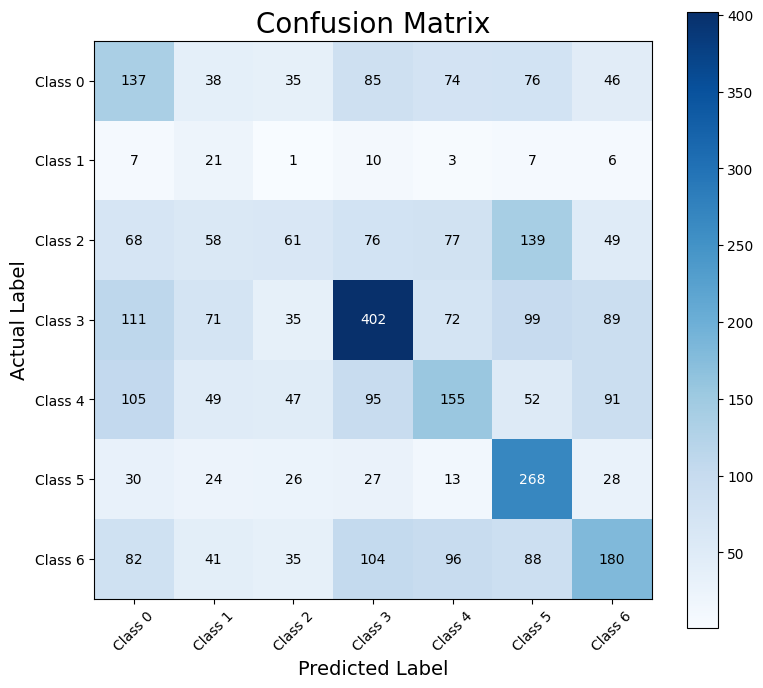

In [15]:
# Example usage:
cm, accuracy, auc_score, class_report = evaluate_model(model_ft, dataloaders['test'], num_classes=num_classes, device="cuda")

print(f"Accuracy: {accuracy:.4f}")
print(f"AUC Score: {auc_score:.4f}")
print("\nClassification Report:\n", class_report)

# Plot confusion matrix
plot_confusion_matrix(cm, class_labels=[f"Class {i}" for i in range(num_classes)], normalize=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.7067103].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5332649..1.6892812].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4048292..1.6369936].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.45620346..1.6892812].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.55038965..1.7067103].


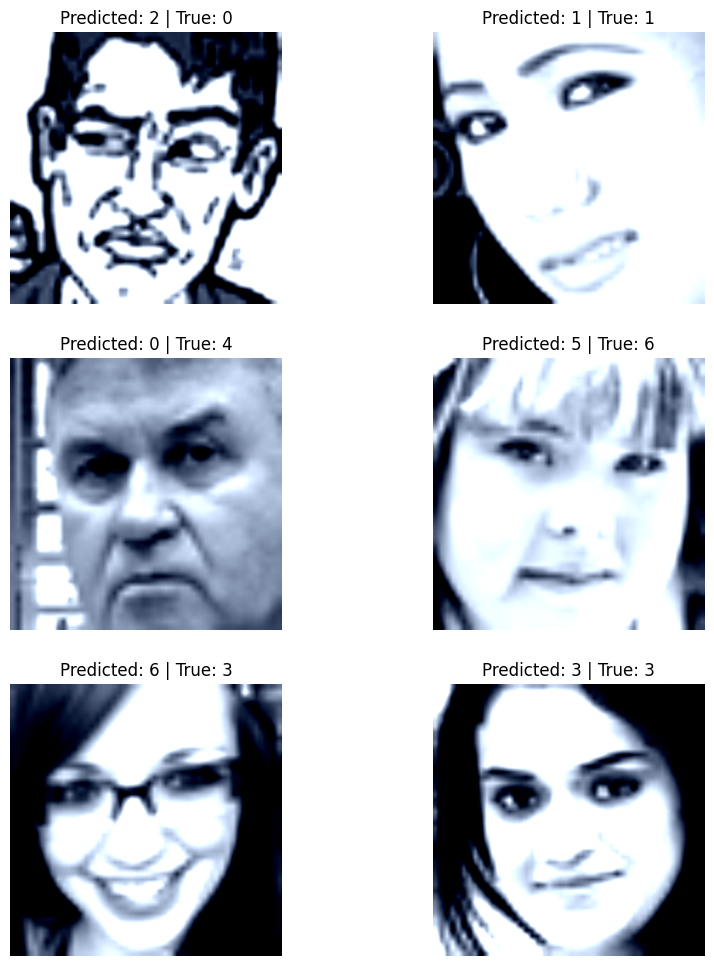

In [16]:
visualize_model(model_ft)

Inference on test dataset
==========================

Use the trained model to make predictions on test dataset and visualize
the predicted class labels along with the images.


In [20]:
import torch
import torchvision.models as models
import torch.nn as nn

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the number of classes (7 in your case)
num_classes = 7

# Initialize the EfficientNet-V2-S model with pre-trained weights
model_ft = models.efficientnet_v2_s(weights="IMAGENET1K_V1")  # Load pre-trained weights
num_ftrs = model_ft.classifier[1].in_features

# Define the same custom classifier as in the original code
model_ft.classifier = nn.Sequential(
    nn.Dropout(p=0.5),  # Dropout before the first layer
    nn.Linear(num_ftrs, 512),  # First hidden layer
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Linear(512, num_classes)  # Output layer
)

# Move model to device
model_ft = model_ft.to(device)

# Load the saved checkpoint
model_path = "models/best_model.pth"  # Update this path if your model is saved elsewhere
checkpoint = torch.load(model_path, map_location=device)

# Extract the model state_dict (assuming it was saved under 'model_state_dict')
if "model_state_dict" in checkpoint:
    saved_state_dict = checkpoint["model_state_dict"]
else:
    saved_state_dict = checkpoint  # If you saved the state_dict directly

# Filter the saved state_dict to only include classifier weights
classifier_state_dict = {k: v for k, v in saved_state_dict.items() if k.startswith("classifier")}

# Load the filtered state_dict into the model
model_ft.load_state_dict(classifier_state_dict, strict=False)

# Set model to evaluation mode
model_ft.eval()

print("Model loaded successfully and ready for inference!")

Model loaded successfully and ready for inference!


Accuracy: 0.2290
AUC Score: 0.6522

Classification Report:
               precision    recall  f1-score   support

           0     0.5000    0.0122    0.0239       491
           1     0.0000    0.0000    0.0000        55
           2     0.2230    0.1288    0.1633       528
           3     0.2808    0.1581    0.2023       879
           4     0.4694    0.0774    0.1329       594
           5     0.1842    0.7308    0.2943       416
           6     0.2637    0.4137    0.3221       626

    accuracy                         0.2290      3589
   macro avg     0.2744    0.2173    0.1627      3589
weighted avg     0.3150    0.2290    0.1891      3589



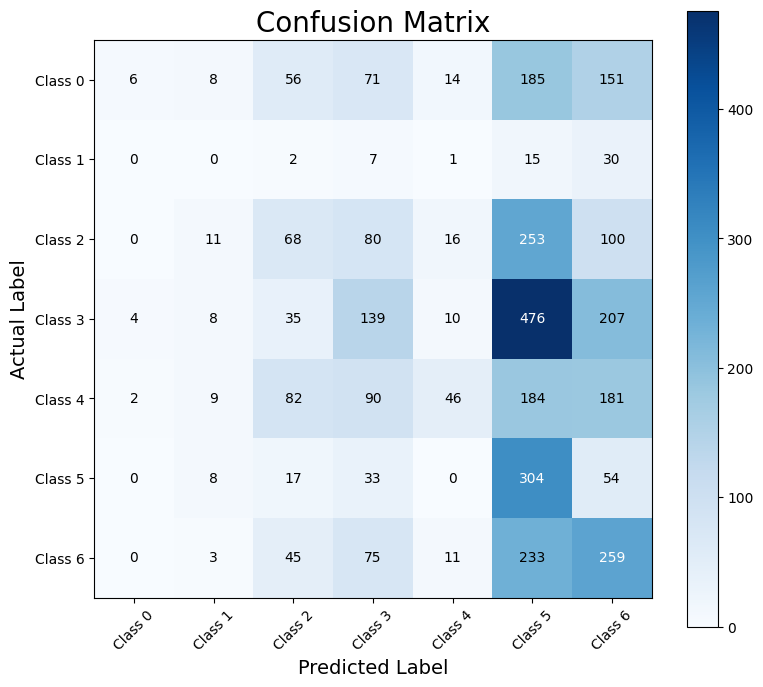

In [21]:
# Example usage:
cm, accuracy, auc_score, class_report = evaluate_model(model_ft, dataloaders['test'], num_classes=num_classes, device="cuda")

print(f"Accuracy: {accuracy:.4f}")
print(f"AUC Score: {auc_score:.4f}")
print("\nClassification Report:\n", class_report)

# Plot confusion matrix
plot_confusion_matrix(cm, class_labels=[f"Class {i}" for i in range(num_classes)], normalize=False)

Accuracy: 0.5621
AUC Score: 0.7374

Classification Report:
               precision    recall  f1-score   support

     Class 0     0.4830    0.4708    0.4768       994
     Class 1     0.3204    0.5893    0.4151        56
     Class 2     0.3225    0.4316    0.3692       760
     Class 3     0.7802    0.7228    0.7504      1955
     Class 4     0.4110    0.4866    0.4456      1044
     Class 5     0.7001    0.6804    0.6901       851
     Class 6     0.5811    0.4651    0.5166      1518

    accuracy                         0.5621      7178
   macro avg     0.5140    0.5495    0.5234      7178
weighted avg     0.5817    0.5621    0.5686      7178



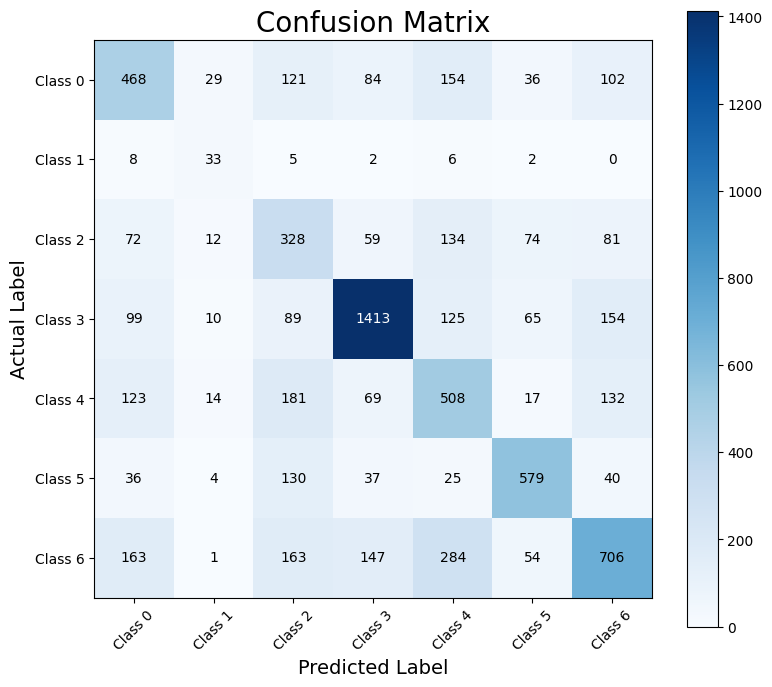

In [22]:

cm = np.array([
    [468,  29, 121,  84, 154,  36, 102],
    [  8,  33,   5,   2,   6,   2,   0],
    [ 72,  12, 328,  59, 134,  74,  81],
    [ 99,  10,  89, 1413, 125,  65, 154],
    [123,  14, 181,  69, 508,  17, 132],
    [ 36,   4, 130,  37,  25, 579,  40],
    [163,   1, 163, 147, 284,  54, 706]
])


num_classes = cm.shape[0]
class_labels = [f"Class {i}" for i in range(num_classes)]  # Create class names

# Compute y_true and y_pred from confusion matrix
y_true = []
y_pred = []
for actual in range(num_classes):
    for predicted in range(num_classes):
        y_true.extend([actual] * cm[actual, predicted])  # Repeat actual class label
        y_pred.extend([predicted] * cm[actual, predicted])  # Repeat predicted class label

# Compute classification metrics
accuracy = accuracy_score(y_true, y_pred)
class_report = classification_report(y_true, y_pred, target_names=class_labels, digits=4)

# Compute AUC score (convert y_true to one-hot encoding)
y_true_bin = np.eye(num_classes)[y_true]  # One-hot encoding
y_pred_bin = np.eye(num_classes)[y_pred]  # One-hot predictions
auc_score = roc_auc_score(y_true_bin, y_pred_bin, multi_class="ovr")

# Function to plot confusion matrix
def plot_confusion_matrix(cm, class_labels, normalize=False):
    plt.figure(figsize=(9, 8))

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # Normalize by row
    
    plt.imshow(cm, interpolation="nearest", cmap="Blues")
    plt.title("Confusion Matrix", fontsize=20)
    plt.colorbar()

    fmt = ".2f" if normalize else "d"
    for i in range(len(cm)):
        for j in range(len(cm[i])):
            plt.text(j, i, format(cm[i, j], fmt), ha="center", va="center", 
                     color="white" if cm[i, j] > cm.max() / 2 else "black")

    plt.xticks(np.arange(len(class_labels)), class_labels, rotation=45)
    plt.yticks(np.arange(len(class_labels)), class_labels)
    plt.xlabel("Predicted Label", fontsize=14)
    plt.ylabel("Actual Label", fontsize=14)
    plt.show()

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"AUC Score: {auc_score:.4f}")
print("\nClassification Report:\n", class_report)

# Plot confusion matrix (normalized)
plot_confusion_matrix(cm, class_labels, normalize=False)